In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.options.display.max_columns=100

In [2]:
norm_loc = '.\\simple_norm_data\\'
files = os.listdir(norm_loc)

ethanol_water = {'w01':[], 'w02':[], 'w03':[],
                 'e01':[], 'e02':[], 'e03':[]}

mapper = {
'A':{1:'S1', 2:'S1', 3:'S1', 4:'S1',
     5:'S2', 6:'S2', 7:'S2', 8:'S2', 
     9:'S3', 10:'S3', 11:'S3', 12:'S3',
     13:'S4', 14:'S4', 15:'S4', 16:'S4'},
'B':{1:'S5', 2:'S5', 3:'S5', 4:'S5',
     5:'S6', 6:'S6', 7:'S6', 8:'S6', 
     9:'S7', 10:'S7', 11:'S7', 12:'S7',
     13:'S8', 14:'S8', 15:'S8', 16:'S8'},
'C':{1:'S9', 2:'S9', 3:'S9', 4:'S9',
     5:'S10', 6:'S10', 7:'S10', 8:'S10', 
     9:'S11', 10:'S11', 11:'S11', 12:'S11',
     13:'S12', 14:'S12', 15:'S12', 16:'S12'},
'D':{1:'S13', 2:'S13', 3:'S13', 4:'S13',
     5:'S14', 6:'S14', 7:'S14', 8:'S14', 
     9:'S15', 10:'S15', 11:'S15', 12:'S15',
     13:'S16', 14:'S16', 15:'S16', 16:'S16'},
'E':{1:'S17', 2:'S17', 3:'S17', 4:'S17',
     5:'S18', 6:'S18', 7:'S18', 8:'S18', 
     9:'S19', 10:'S19', 11:'S19', 12:'S19',
     13:'S20', 14:'S20', 15:'S20', 16:'S20'}
}

#Neither of these are used currently:
exposures = {'1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[]}
all_data = {}

for f in files:
    f = norm_loc + f
    selector_group = f[-6]
    if f[-16] == 'e':
        compound = 'e' + f[-9:-7]
    else:
        compound = 'w'+f[-9:-7]
    to_replace = mapper[selector_group]
    data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
    for key in data_set.iterkeys():
        data_set[key] = data_set[key].set_index(0)
        data_set[key] = data_set[key].rename(columns=to_replace)
    ethanol_water[compound].append(data_set['Sheet1']) # Currently working with just the first exposure
for comp in ethanol_water:  
    ethanol_water[comp] = pd.concat(ethanol_water[comp], axis=1)

In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [11]:
def avg_all_to_all_dist(m1, m2):
    distances = []
    for i in range(m1.shape[0]):
        for j in range(m2.shape[0]):
            distances.append(euclidean(m1[i,:], m2[j,:]))
    distances = np.asarray(distances)
    distance_mean = distances.mean()
    return distance_mean

def dist_water_and_ethanol(selector1, selector2):
    '''
    currently hardcoded for the water-ethanol datasets assuming sorted input! ie ethanol first, then water
    '''
    ethanol_dist = avg_all_to_all_dist(selector1[:12,:], selector2[:12,:])
    water_dist = avg_all_to_all_dist(selector1[12:,:], selector2[12:,:])
    return water_dist, ethanol_dist

[[   4.89224627   22.64912528    5.44793896   20.64711031   18.52338285
    20.18367992  103.66804599  104.03458834   10.21519872    6.79711439
    11.05404003   11.70120804    7.19896458    7.28224434   28.22291429
    16.70960281   23.7367183    11.73880505    9.39339275   19.11318317]
 [  22.64912528   10.04104002   19.11169091   16.06776626   12.1639791
    10.24227078  121.8971006   124.78038527   13.44873134   18.06590989
    12.68947057   12.04662174   17.18617737   16.59911707   19.22533982
    11.40928388    9.73098097   12.25668656   14.50527401   14.53960573]
 [   5.44793896   19.11169091    3.75833657   18.21369468   15.1357024
    16.6053406   106.10714922  107.04636799    6.74957548    4.99208003
     7.53237669    8.1339691     5.02176321    4.43914757   25.54882028
    13.27480599   20.12872014    8.16883492    5.95583273   16.04738652]
 [  20.64711031   16.06776626   18.21369468   12.55918512   19.23163031
    15.93904224  122.57073508  123.34929891   15.11615336   18.

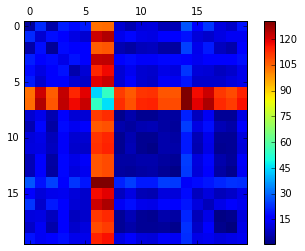

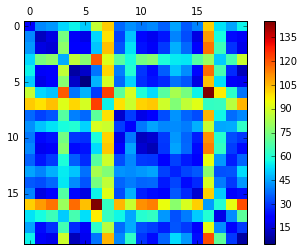

In [17]:
# times slice to use for the distance calculation
start = 300
end = 450
# make an array of the labels for the data:
labels = np.array([[1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

all_data = []
for i in range(1,21):
    selector = []
    for w in sorted(ethanol_water.keys()):
        selector_data = ethanol_water[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    all_data.append(selector)
water_distances = []
ethanol_distances = []
for s1 in all_data:
    for s2 in all_data:
        water_dis, ethanol_dis = dist_water_and_ethanol(s1,s2)
        water_distances.append(water_dis)
        ethanol_distances.append(ethanol_dis)
water_distances = np.asarray(water_distances)
water_distances = water_distances.reshape((20,20))
ethanol_distances = np.asarray(ethanol_distances)
ethanol_distances = ethanol_distances.reshape((20,20))
print(water_distances)

# dist_lin = pdist(all_data)
fig = plt.figure()
# max_dist = 30
# water_distances[water_distances > max_dist] = max_dist
# ethanol_distances[ethanol_distances > max_dist] = max_dist
ax = fig.add_subplot(111)
cax = ax.matshow(water_distances)
fig.colorbar(cax)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ethanol_distances)
fig.colorbar(cax)
plt.show()

The following cell is for just plotting the heatmaps of distances with an all-to-all comparision of the individual selectors

Selector number: 1


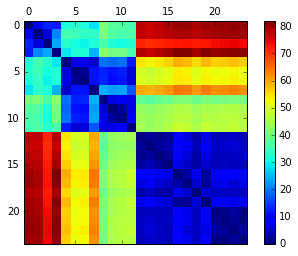

Selector number: 2


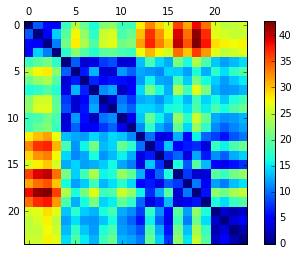

Selector number: 3


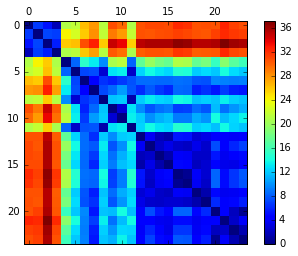

Selector number: 4


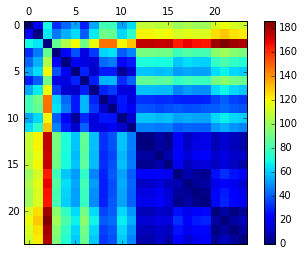

Selector number: 5


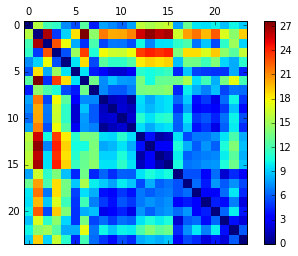

Selector number: 6


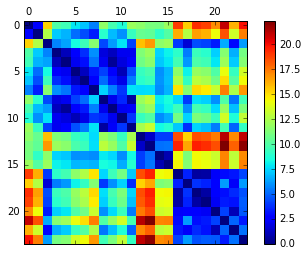

Selector number: 7


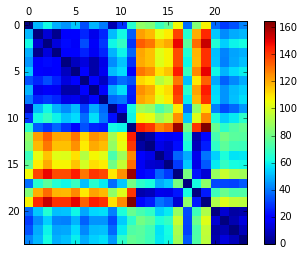

Selector number: 8


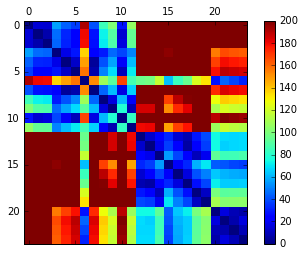

Selector number: 9


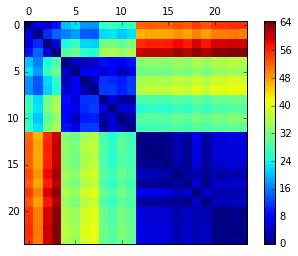

Selector number: 10


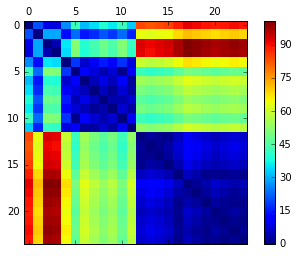

Selector number: 11


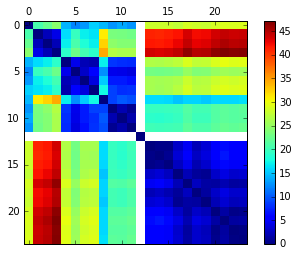

Selector number: 12


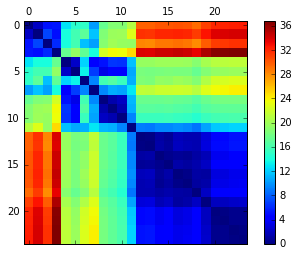

Selector number: 13


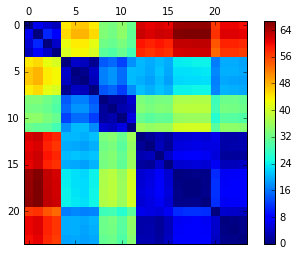

Selector number: 14


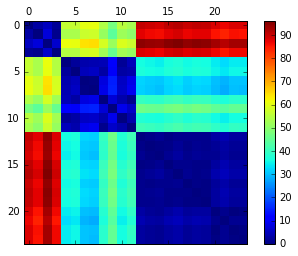

Selector number: 15


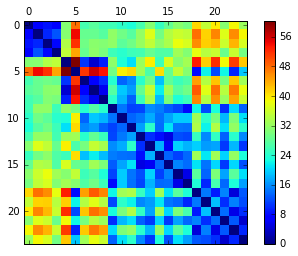

Selector number: 16


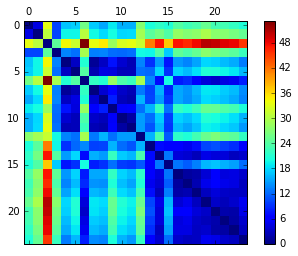

Selector number: 17


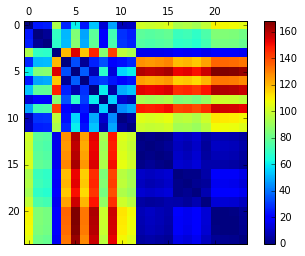

Selector number: 18


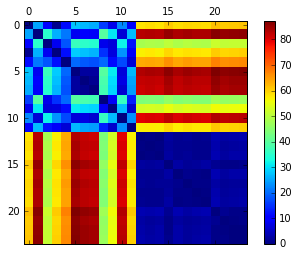

Selector number: 19


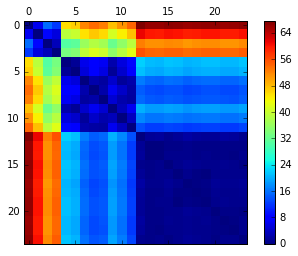

Selector number: 20


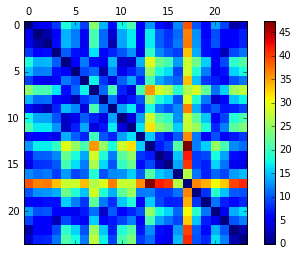

In [51]:
random_drop = False
number_to_keep = 50 # how many do you want to keep?
max_dist = 200 # cap the maximum distance in the plots so the scaling is reasonable
# times slice to use for the distance calculation
start = 300
end = 450
# make an array of the labels for the data:
labels = np.array([[1,2]])
labels = np.repeat(labels, 12, axis=1).flatten()

for i in range(1,21):
    selector = []
    for w in sorted(ethanol_water.keys()):
        selector.append(ethanol_water[w]['S'+str(i)])
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    if random_drop:
        rand_kept = np.random.choice(selector.shape[1], number_to_keep)
        selector = selector[:,rand_kept]

    dist_lin = pdist(selector)
    dist_sq = squareform(dist_lin)
    dist_sq[dist_sq > max_dist] = max_dist
    print('Selector number: {}'.format(i))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(dist_sq)
    fig.colorbar(cax)
    plt.show()

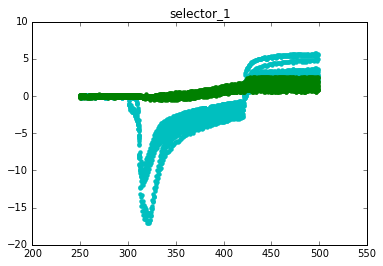

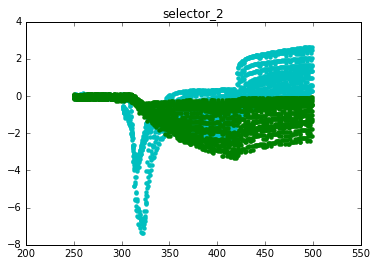

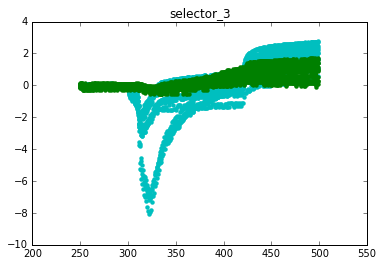

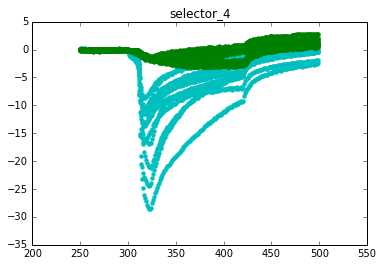

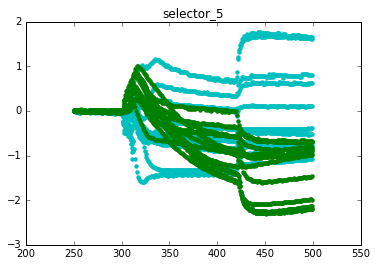

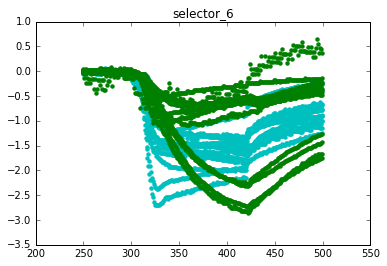

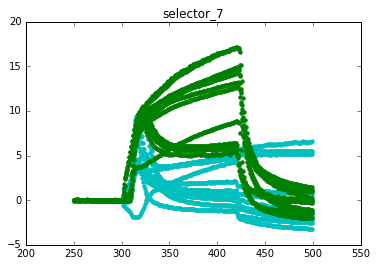

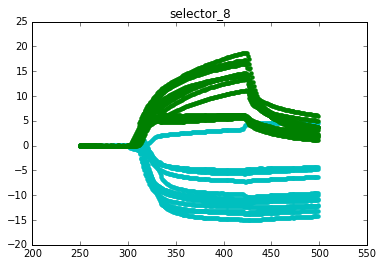

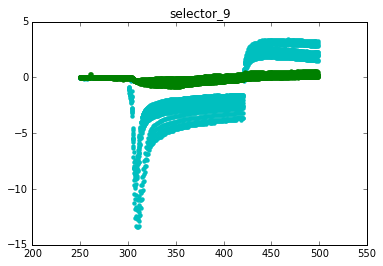

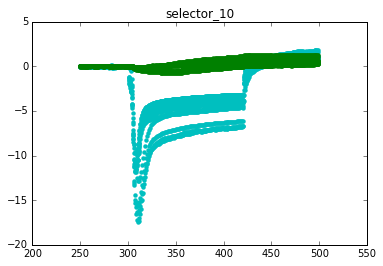

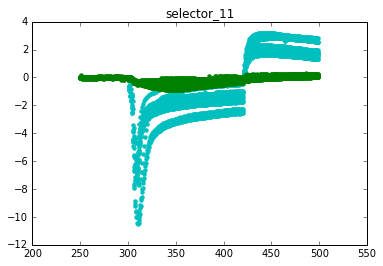

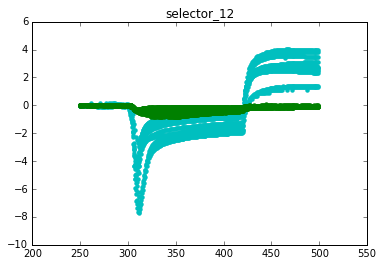

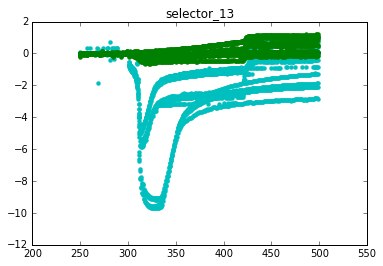

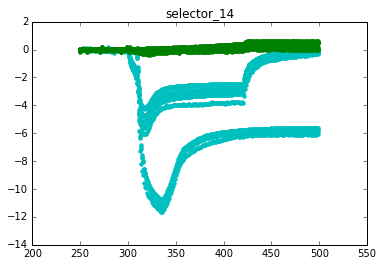

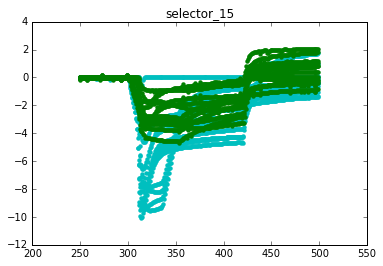

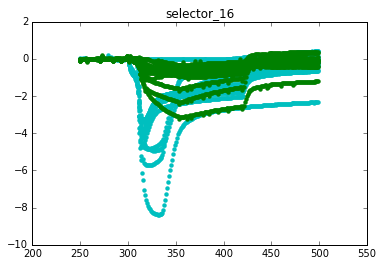

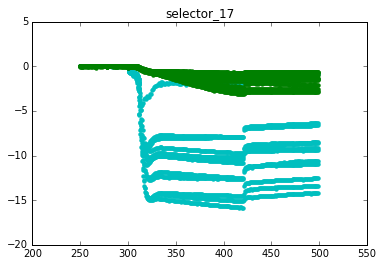

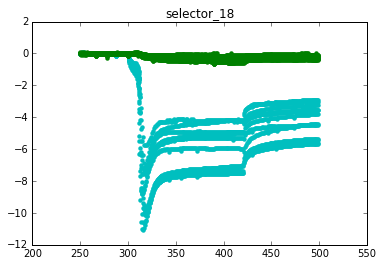

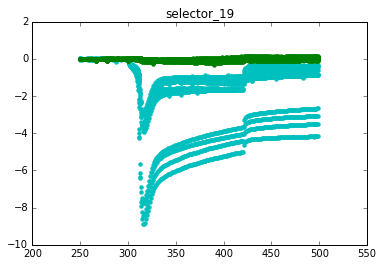

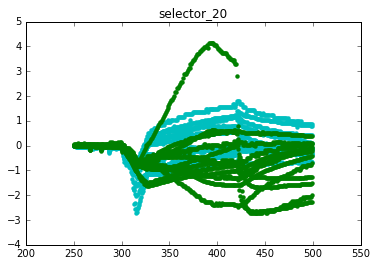

In [11]:
colors = ['c','c','c','c','c','c','c','c','c','c','c','c',
          'g','g','g','g','g','g','g','g','g','g','g','g']
for i in range(1,21):
    selector = []
    for w in sorted(ethanol_water.keys()):
        selector.append(ethanol_water[w]['S'+str(i)])
    selector = pd.concat(selector, axis=1)

    for j,c in enumerate(colors):
        y = selector.iloc[:,j].values[250:500]
        x = list(selector.index)[250:500]
        plt.scatter(x,y,c=c, linewidth=0)
    plt.title('selector_{}'.format(i))
    plt.show()

This following cell is for using each selector individually with kNN, RF, lr and SVM classifiers and then using majority voting over there classifiers. <br>

In [4]:
def get_classifier(classifier):
    if classifier == 'LR':
        return LogisticRegressionCV(cv=3, penalty='l1', solver='saga')
    elif classifier == 'RF':
        return RandomForestClassifier(n_estimators=100)
    elif classifier == 'KNN':
        return KNeighborsClassifier(n_neighbors=4)
    elif classifier == 'SVM': # using the default RBF kernel..
        return SVC() 
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
        return
    
def get_majority_vote(vote_count_dict):
    highest_count = 0
    key_highest = None
    for k,v in vote_count_dict.items():
        if v > highest_count:
            highest_count = v
            key_highest = k
    return key_highest

In [92]:
# do you want to randomly drop parts of the input and shuffle to avoid dependence between features (ie different time points
# in a single time course)
random_drop = False
num_to_keep = 50
# what time window do you want to use?
start = 300
end = 450
classifier = 'KNN' # Use LR - logistic regression, RF - random forest, KNN - k-nearest neighbors, SVM - support vector machine
# fit models on all combos of the data blocks: 
blocks = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[20,21,22,23]]
block_combos = [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)]

#get a array for the labels for the wines...there are four wines so four labels
labels = np.array([[0,1]])
labels = np.repeat(labels, 12, axis=1).flatten()

accuracies = []
for combo in block_combos:
    print('On combo: ', combo)
    print('starting selector classifier training...')
    # each combo will give 20 models where each 
    pred_test_combined = []
    for i in range(1,21):
        selector = []
        for w in sorted(ethanol_water.keys()):
            selector_data = ethanol_water[w]['S'+str(i)]
            # In case data is missing this imputes via the mean; probably a better idea to just drop...
            # (but the ethanol-water does not have this issue)
            selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
            selector.append(selector_data)
        selector = pd.concat(selector, axis=1)
        selector = selector.values.T
        selector = selector[:, start:end]
        if random_drop:
            rand_kept = np.random.choice(selector.shape[1], num_to_keep)
            selector = selector[:,rand_kept]
        mask_test = blocks[combo[0]]+blocks[combo[1]]
        mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
        x_test = selector[mask_test,:]
        x_train = selector[mask_train,:]
        y_test = labels[mask_test]
        y_train = labels[mask_train]
        
        clf = get_classifier(classifier)
        x_train, y_train = shuffle(x_train, y_train)
        clf.fit(x_train, y_train)
        pred_test_combined.append(clf.predict(x_test)) # might be better to work with probablilites... predict_proba
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies.mean(), '+/-', accuracies.std())

(1.0, '+/-', 0.0)


This following cell is for using a SINGLE vector of all selectors with kNN, RF, LR and SVM classifiers. <br>
It concatenates vectors in a first to first, second to second etc manner (ie the first column of each selector is one final vector)

Accuracy @ 0.95 confidence: 1.00 (+/- 0.00)


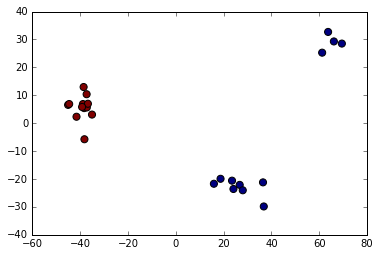

In [69]:
# do you want to randomly drop parts of the input and shuffle to avoid dependence between features (ie different time points
# in a single time course)
random_drop = False
rand_num = 50
# what time window do you want to use?
start = 300
end = 450
# run classification?
classify = True
classifier = 'KNN' # Use LR - logistic regression, RF - random forest, KNN - k-nearest neighbors, SVM - support vector machine
# do you want to pick the test set? 
pick_test = False # if true need to supply the next line which is the indicies of the test set
test_set = [0,1,2,3,16,17,18,19]

# run pca on the final data matrix?
run_pca = True

labels = np.array([[0,1]])
labels = np.repeat(labels, 12, axis=1).flatten()

full_data = []
first = True
for i in range(1,21):
    selector = []
    for w in sorted(ethanol_water.keys()):
        selector_data = ethanol_water[w]['S'+str(i)]
        # In case data is missing this imputes via the mean; probably a better idea to just drop...
        # (but the ethanol-water does not have this issue)
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1) 
    selector = selector.values.T[:,start:end]
    if random_drop:
        if first:
            rand_dropped = np.random.choice(selector.shape[1], rand_num)
            first = False
        selector = selector[:,rand_dropped]
    full_data.append(selector)
full_data = np.concatenate(full_data, axis=1)

if classify:  
    if classifier == 'LR':
        clf = LogisticRegressionCV(cv=3, penalty='l1', solver='saga')
    elif classifier == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    elif classifier == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=4)
    elif classifier == 'SVM': # using the default RBF kernel..
        clf = SVC() 
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
    
    ## this is if you want to SPECIFY which examples to use for test:
    if pick_test:
        mask_test = np.asarray(test_set) #make sure to have some from each class!
        mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]    
        x_test = full_data[mask_test,:]
        x_train = full_data[mask_train,:]
        y_test = labels[mask_test]
        y_train = labels[mask_train]
        x_train, y_train = shuffle(x_train,y_train)
        clf.fit(x_train, y_train)
        print('Accuracy: %0.2f' % (clf.score(x_test, y_test)))
    
    else:
        try:
            full_data, labels = shuffle(full_data, labels)
            scores = cross_val_score(clf, full_data, labels, cv=4)
            print("Accuracy @ 0.95 confidence: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        except:
            pass
        
if run_pca:
    ss = StandardScaler()
    pca = PCA(n_components=4)
    X = ss.fit_transform(full_data)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=labels)
    plt.show()